# Time series forecast procedure

A time series (TS) is a collection of datapoints collected at constant time intervals. With TS it is possible to determine the long term trend in order to forecast the future. 

The problem we are going to solve is the forecast of future short-term sales (15 days forecast). What we start building here is a proof of concept (PoC) to forecast only 2 time series, which should be the starting point to perform later the forectast of around 55,000 different products.

Some factors such as the relation of sales between products and its accesories, marketing activities, competitors activities, pricing, etc. will not be considered.

Although regression and time series prediction are different problems, we will rephrase this TS assignment as a regression problem and develop a neural network model for it.

Below we will start with a simple procedure to make a PoC for forecasting 2 time series of product sales.

In [1]:
#Import libraries
import csv
import numpy
import math
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


# Loading and handling time series
We can load the data and look at the initial rows and data types of the columns:

In [2]:
training = pd.read_csv('training.csv')
print training.head()
print '\n Data Types:'
print training.dtypes

       TSDate serieNames  sales
0  2013-06-21    serie_1   1248
1  2013-06-21    serie_2    695
2  2013-06-22    serie_2      5
3  2013-06-22    serie_1      0
4  2013-06-23    serie_1      0

 Data Types:
TSDate        object
serieNames    object
sales          int64
dtype: object


Let’s understand the arguments one by one:

* TSDate: This column represents the date in the format YYYY-MM-DD from 2013-06-21 to 2015-11-15. We get the daily sales of two products.
* serieNames: Specifies if the row data belongs to series_1 or to series_2.
* sales: This column has integers with the actual sales per day.

Although we know currently there is just data of 2 time series, we want to ensure the code is scalable for more products, therefore, we get the number of time series automatically.

In [3]:
serieNames = training.serieNames.unique()
print len(serieNames)

2


As we have 2 time series in the training data (serie_1 & serie_2), we split our training data for each one, therefore, it will be easier in the future to build the training input vectors.

In [4]:
#Open "training.csv" and "test.csv" files,
#specify "TSDate" is the column which contains the date-time information,
#and convert the strings of this column into datetime variable
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
training = pd.read_csv('training.csv', parse_dates=['TSDate'], index_col='TSDate', date_parser=dateparse)
testing = pd.read_csv('test.csv', parse_dates=['TSDate'], index_col='TSDate', date_parser=dateparse)

#Write a .csv file
def write_file (serieName, sales):
    with open(serieName, 'w') as csvfile:
        fieldnames = ['TSDate', 'sales']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for date in sales.index:
            writer.writerow({'TSDate':date, 'sales':sales[date]})

#Divide and write a .csv file per TS
for serie in serieNames:
    serieData = training.loc[(training.serieNames == serie)]
    sales = serieData['sales']
    write_file(serie, sales)

We are going to keep things simple for this PoC and work with the data as it is. For a more complex and accurate solution, it is a good idea to investigate various data preparation techniques to rescale and to make it stationary. In a second stage, we will apply some techniques as:

1. Rescale: Apply transformations that penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc.
2. Stationary data: We have checked stationarity of both TS and the data is clearly non-stationary, therefore, we would like to apply some popular techniques as differencing in order to remove trend and seasonality in the future.

# Reshaping the training and testing datasets

Now that we have divided the sales values for each time series and we know that each observation is separated by the same interval of one day, we can load the dataset without the "TSDate" column. We will convert the integer sales values to floating point, which are more suitable for modelling neural networks.

In order to rephrase the TS problem as a regression problem, we will use the window method. Therefore, we will use multiple time steps to make a prediction for the next time step. After tuning the size of the window, we chose 10 days of previous sales to predict the sales of the 11th day. This means: given the current time (t), we want to predict the value at the next time in the sequence (t + 1), we can use the current time (t) as well as the 9 prior times (t-1, t-2, t-3, t-4, t-5, t-6, t-7, t-8 and t-9).

When rephrased as a regression problem, the output variable is t+1, while the input variables are t-9, t-8, t-7, t-6, t-5, t-4, t-3, t-2, t-1, t and, additionally, a value that indicates the number of the series (either 1 or 2) to differentiate if this datapoint belongs to serie_1 or to serie_2.

The create_dataset() takes three arguments, the dataset which is a NumPy array, the number of the series, and the lookBack,  which is the number of previous time steps to use as input variables to predict the next time period, in this case, set to 10.

This simple function converts our data into a training dataset. The X containing ten days of sales and the Y containing 11th day sales, to be predicted.

In [5]:
#Convert an array of values into a dataset matrix
def create_dataset(dataset, series, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookBack):
        a = dataset[i:(i+lookBack), 0]
        a = numpy.insert(a, 0, series, axis=0)
        dataX.append(a)
        dataY.append(dataset[i + lookBack, 0])
    return numpy.array(dataX), numpy.array(dataY)
    
#Fix random seed for reproducibility
numpy.random.seed(20)

#Initialise the number of TS in the dataset
serieNumber = 1

#Load the dataset
for serie in serieNames:
    dataframe = pd.read_csv(serie, usecols=[1], engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    #Split into train and test sets
    lookBack = 10
    train, test = dataset, dataset[len(dataset)-lookBack:, :]
    test = numpy.append(test, [[0]], axis=0)
    #Reshape dataset
    trainXTemp, trainYTemp = create_dataset(train, serieNumber, lookBack)
    testXTemp, testYTemp = create_dataset(test, serieNumber, lookBack)
    if 'trainX' in dir():
        trainX = numpy.append(trainX, trainXTemp, axis=0)
        trainY = numpy.append(trainY, trainYTemp, axis=0)
        testX = numpy.append(testX, testXTemp, axis=0)
    else:
        trainX = trainXTemp
        trainY = trainYTemp
        testX = testXTemp      
    serieNumber += 1

# Training a multilayer perceptron model

We can now fit a multilayer perceptron model to the training data.

We use a simple network with 1 input of dimension 11, 1 hidden layer with 12 neurons and an output layer of dimension 1. The model is fitted using mean squared error.

We tried a greedy selection of parameters, taking out a validation set from the training data, in order to minimise the mean square error (MSE) of the testing, and not just the MSE of the training. Based on that, we settled on the configuration below.

In [6]:
#Fit a Multilayer Perceptron Model
model = Sequential()
model.add(Dense(12, input_dim=lookBack+1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=2)

#Estimate model performance on training data
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

Epoch 1/200
1s - loss: 1098664.0236
Epoch 2/200
1s - loss: 299362.7851
Epoch 3/200
1s - loss: 263067.1065
Epoch 4/200
2s - loss: 245058.5575
Epoch 5/200
1s - loss: 234502.3852
Epoch 6/200
2s - loss: 234849.0126
Epoch 7/200
1s - loss: 226524.0032
Epoch 8/200
1s - loss: 229977.5881
Epoch 9/200
1s - loss: 227116.3001
Epoch 10/200
1s - loss: 224183.8566
Epoch 11/200
1s - loss: 225741.1916
Epoch 12/200
1s - loss: 220794.0240
Epoch 13/200
1s - loss: 221692.8068
Epoch 14/200
1s - loss: 218430.7257
Epoch 15/200
1s - loss: 215744.8568
Epoch 16/200
1s - loss: 221040.4587
Epoch 17/200
1s - loss: 215959.8289
Epoch 18/200
1s - loss: 217215.7331
Epoch 19/200
1s - loss: 215318.1808
Epoch 20/200
1s - loss: 216347.4254
Epoch 21/200
1s - loss: 213938.3791
Epoch 22/200
1s - loss: 210541.5045
Epoch 23/200
1s - loss: 205665.3667
Epoch 24/200
1s - loss: 213324.5935
Epoch 25/200
2s - loss: 207409.5876
Epoch 26/200
1s - loss: 207222.7672
Epoch 27/200
1s - loss: 205644.1277
Epoch 28/200
1s - loss: 205937.2776


Finally, we can generate predictions using the model for both, the training and the testing datasets. 

In [7]:
#Generate predictions for training
trainPredict = model.predict(trainX)
#Generate predictions for testing
testPredict = model.predict(testX)

# Generating 15-days forecast

In the last code line, we generated the prediction for the testing dataset. However, this prediction only includes the first day of sales out of 15 days of forecast for each time series, as we can see.

In [8]:
print len(testPredict)

2


We have to remember that we use the sales values of ten days before in order to predict the next sales values. The trainig dataset has sales from 2013-06-21 to 2015-11-15 and we want to predict expected sales from 2015-11-16 to 2015-11-30. The prediction already made was for 2015-11-16 using the sales from the previous 10 days (2015-11-06 to 2015-11-15) which are in the training set. However, to predict the sales for 2015-11-17 we have to wait for the prediction of November 16th, so we can have the 10 previous days of sales, from 2015-11-07 to 2015-11-16 (assuming that our predictions are similar to the real values).

The update_testX() method, takes the testX array once we have made a prediction, and includes this prediction in this array, so we are able to make the next prediction of sales. The method is called 14 times successively, therefore, we have the forecast for 15 days in total.

In [9]:
#Include last prediction in testX
def update_testX(testX):
    testX = numpy.roll(testX, -1)
    for i in range(len(serieNames)):
        numpy.put(testX[i], [0, lookBack], [i+1, testPredict[i]])
    return testX

#Generate sales predictions for 14 more days
testY = testPredict
for i in range(14):
    testX = update_testX(testX)
    testPredict = model.predict(testX)
    testY = numpy.append(testY, testPredict, axis=0)

We save the results of the 15-days sales prediction in a file called "test.csv". We also save the results of the model fitting in a file called "model.csv". Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis (dates) with the original dataset.

In [10]:
#Write a .csv with the results of the forecast
def write_results (dates, serieNames, sales):
    with open('test.csv', 'w') as csvfile:
        fieldnames = ['TSDate', 'serieNames', 'sales']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(len(sales)):
            writer.writerow({'TSDate': dates[i].date(), 'serieNames': serieNames[i%len(serieNames)], 'sales': round(sales[i])})
            
write_results(testing.index, serieNames, testY)

#Write a .csv with the results of the fitting model
#TODO: Optimise the write methods and create just 1 method to write both files, test.csv and model.csv
def write_model (dates, serieNames, sales):
    with open('model.csv', 'w') as csvfile:
        fieldnames = ['TSDate', 'serieNames', 'sales']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(len(sales)/len(serieNames)):
            writer.writerow({'TSDate': dates[i*len(serieNames)].date(), 'serieNames': serieNames[0], 'sales': round(sales[i])})
            writer.writerow({'TSDate': dates[i*len(serieNames)].date(), 'serieNames': serieNames[1], 'sales': round(sales[i+(len(sales)/len(serieNames))])})
    
write_model(training.index[lookBack*len(serieNames):], serieNames, trainPredict)

# Graphical output of the model fitting of the TS and the forecast

Once prepared, the data is plotted.

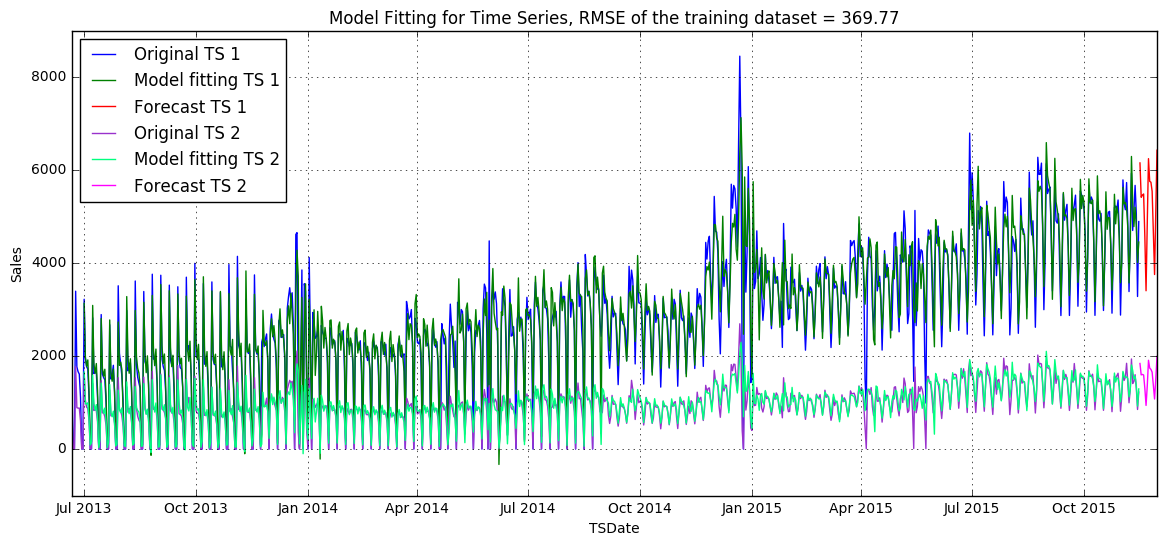

In [11]:
#Get training values of serie_1 and serie_2
serie1 = training.loc[(training.serieNames == 'serie_1')]['sales']
serie2 = training.loc[(training.serieNames == 'serie_2')]['sales']

#Get the fitting model of serie_1 and serie_2
model = pd.read_csv('model.csv', parse_dates=['TSDate'], index_col='TSDate',date_parser=dateparse)
model1 = model.loc[(model.serieNames == 'serie_1')]['sales']
model2 = model.loc[(model.serieNames == 'serie_2')]['sales']

#Get the 15-days forecast of serie_1 and serie_2
forecast = pd.read_csv('test.csv', parse_dates=['TSDate'], index_col='TSDate',date_parser=dateparse)
forecast1 = forecast.loc[(forecast.serieNames == 'serie_1')]['sales']
forecast2 = forecast.loc[(forecast.serieNames == 'serie_2')]['sales']

#Generate graphical output
plt.figure(figsize=(14,6))
#Plots of TS1
orig = plt.plot(serie1, color='blue', label='Original TS 1')
orig = plt.plot(model1, color='green', label='Model fitting TS 1')
orig = plt.plot(forecast1, color='red', label='Forecast TS 1')
#Plots of TS2
orig = plt.plot(serie2, color='darkorchid', label='Original TS 2')
orig = plt.plot(model2, color='springgreen', label='Model fitting TS 2')
orig = plt.plot(forecast2, color='magenta', label='Forecast TS 2')

plt.grid()
plt.legend(loc='best')
plt.title('Model Fitting for Time Series, RMSE of the training dataset = %.2f' % math.sqrt(trainScore))
plt.ylabel('Sales')
plt.xlabel('TSDate')
plt.show(block=False)

Taking the square root of the performance score, we can notice that the average error on the training dataset is around 365 sales per day. Looking at the graph, we can see the structure in the predictions. The model generated by the neural network is trying to follow the shape of the time series and it generates a forecast according to the training information.